- **a little bit of EDA (this competition doesn't need much of an EDA)**
- how to cross-validate correctly
- how to preprocess the data for various classifiers
- how to tune the most important hyperparameters of some models
- how an ensemble performs better than any single model

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier

np.set_printoptions(linewidth=195, edgeitems=5)

# Reading the data

In [2]:
data_path = '../data/'

train = pd.read_csv(data_path+'train.csv', index_col='id')
test = pd.read_csv(data_path+'test.csv', index_col='id')
original = pd.read_csv(data_path+ 'jm1.csv', na_values=['?'])
original2 = pd.read_csv(data_path+ 'jm1.csv')

submission_df = pd.read_csv(data_path+'sample_submission.csv', index_col='id')
with pd.option_context("display.min_rows", 6):
    display(train)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False
101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,77011.02,...,102,1,11,0,22.0,31.0,162.0,135.0,35.0,False


# EDA

There are no missing values

In [3]:
train.isna().sum().sum()

0

There are no duplicates

In [4]:
train.duplicated().sum()

0

The dataset is somewhat unbalanced: Only 23 % of the samples belong to the positive class (i.e., have defect==True)

We'll use a StratifiedKFold for cross-validation. There is no need for upsampling, downsampling or similar voodoo.

In [5]:
train.defects.mean()

0.22664426166681406

- The dataset has >100000 rows. For some algorithms (e.g., kernel methods or Neighborhood Components Analysis), this is too much.
-  more than 100000 rows with 21 features is abundant data. We don't need to worry much about overfitting.

In this competition, we don't need a fancy EDA with a lot of colorful diagrams. We can learn much more about the data by tuning and cross-validating a few machine learning models.

Two points, however, are worth mentioning:

1. There are **significant** differences between the original and the synthetic data. I wouldn't include the original data in training.
2. All 21 features are nonnegative and their distributions are right-skewed, resembling an exponential distribution. A log-transformation is recommended.

### Differences between original and synthetic data

`train` and `test` of this competition consist of synthetic data, which was generated based on the real-world dataset `original`. The distributions are not the same, however.

The description of the [original dataset] says that nine columns of the dataset are "derived measures":

- P = volume = V = N * log2(mu) (the number of mental comparisons needed to write a program of length N)
- V = volume on minimal implementation = (2 + mu2')log2(2 + mu2')
- L = program length = V*/N
- D = difficulty = 1/L
- L' = 1/D
- I = intelligence = L'*V'
- E = effort to write program = V/L
- T = time to write program = E/18 seconds
Two examples (in the form of diagrams) suffice to show that these relationships don't hold for the synthetic data, and the ratio of defects differs between the datasets anyway:

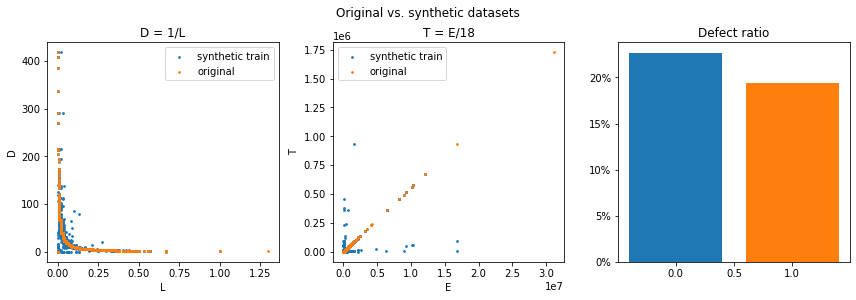

In [6]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(train.l, train.d, s=3, label='synthetic train')
ax1.scatter(original.l, original.d, s=3, label='original')
ax1.set_xlabel('L')
ax1.set_ylabel('D')
ax1.set_title('D = 1/L')
ax1.legend()
ax2.scatter(train.e, train.t, s=3, label='synthetic train')
ax2.scatter(original.e, original.t, s=3, label='original')
ax2.set_xlabel('E')
ax2.set_ylabel('T')
ax2.set_title('T = E/18')
ax2.legend()
bars1 = ax3.bar([0], [train.defects.mean()*100])
bars2 = ax3.bar([1], [original.defects.mean()*100])
ax3.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
# ax3.bar_label(bars1, fmt='{:.0f}%')
# ax3.bar_label(bars2, fmt='{:.0f}%')
# ax3.set_xticks([0, 1], ['synthetic\ntrain', 'original'])
ax3.set_title('Defect ratio')
plt.tight_layout()
plt.suptitle('Original vs. synthetic datasets', y=1.03)
plt.show()

**Insight**: In view of these differences, I recommend not to use the original dataset for training models.

### A log-transformation is recommended

All 21 features are nonnegative and their histograms are right-skewed, resembling an exponential distribution.

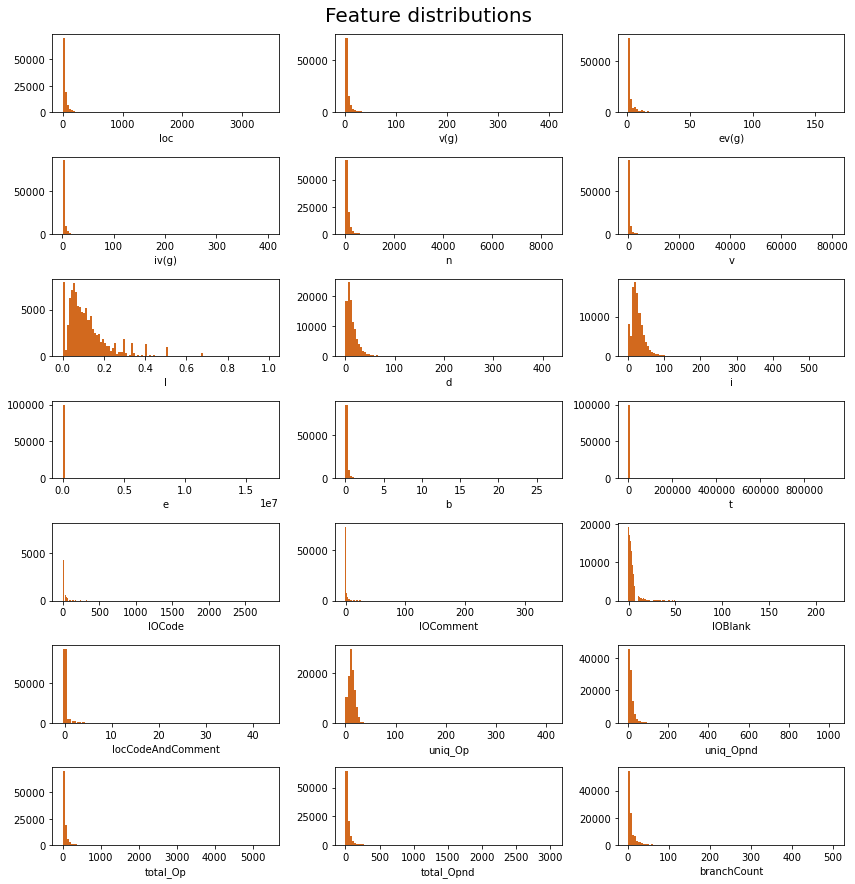

In [7]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test.columns, axs.ravel()):
    if train[col].dtype == float:
        ax.hist(train[col], bins=100, color='chocolate')
    else: #int
        vc = train[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

**Insight**: With this kind of distributions, many models profit if we log-transform the data by prepending a FunctionTransformer(np.log1p) to the pipeline.

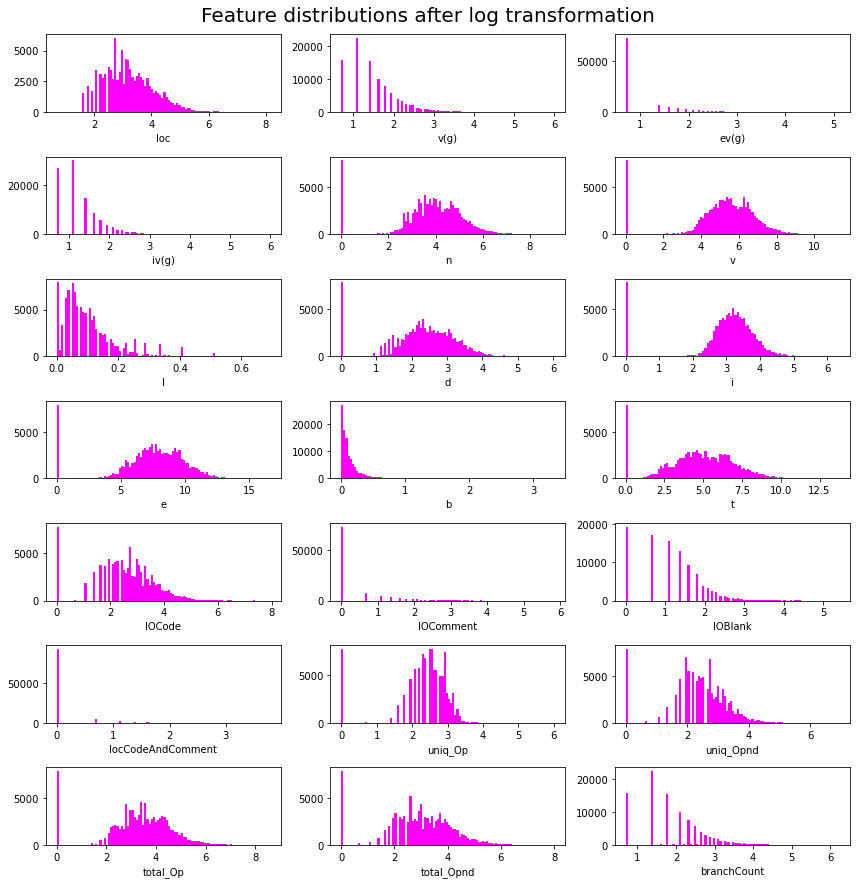

In [8]:
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test.columns, axs.ravel()):
    ax.hist(np.log1p(train[col]), bins=100, color='magenta')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

# Cross-validation

In [9]:
result_list = []

In [10]:
def cross_val(model, label):
    """Cross-validate the model with a StratifiedKFold
    
    The cross-validation score is printed and added to the global result_list"""
    start_time = datetime.now()
    kf = StratifiedKFold(shuffle=True, random_state=61)
    oof = np.full(len(train), np.nan)
    auc_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.defects)):
        X_tr = train.iloc[idx_tr]
        X_va = train.iloc[idx_va]
        y_tr = X_tr.pop('defects')
        y_va = X_va.pop('defects')
        model.fit(X_tr, y_tr)
#         print(np.round(model[-1].coef_, 2), np.round(model[-1].intercept_, 2))
        try:
            y_va_pred = model.predict_proba(X_va)[:, 1]
        except AttributeError: # 'LinearSVC' object has no attribute 'predict_proba'
            y_va_pred = model.decision_function(X_va)
        oof[idx_va] = y_va_pred
        auc = roc_auc_score(y_va, y_va_pred)
        auc_list.append(auc)
    auc = np.array(auc_list).mean()
    execution_time = datetime.now() - start_time
    print(f"# AUC {auc:.5f}   time={str(execution_time)[-15:-7]}   {label}")
    result_list.append((auc, label, execution_time))
#     plt.figure(figsize=(6, 2))
#     plt.hist(oof, bins=200, density=True)
#     plt.show()
    return auc

In [11]:
def plot_score_list(label, parameter, xscale='linear'):
    """Show a scatterplot of the scores in the global variable score_list"""
    plt.figure(figsize=(6, 3))
    plt.scatter([p for p, s in score_list],
                [s for p, s in score_list])
    plt.xscale(xscale)
    plt.xlabel(f'{parameter}{" (log-scale)" if xscale == "log" else ""}')
    plt.ylabel('AUC score')
    plt.title(label)
    plt.show()

# AUC 0.78653   time=0:00:24   Poly-LinearSVC C=0.0001
# AUC 0.78806   time=0:00:48   Poly-LinearSVC C=0.001
# AUC 0.78858   time=0:01:23   Poly-LinearSVC C=0.01
# AUC 0.78823   time=0:03:02   Poly-LinearSVC C=0.1


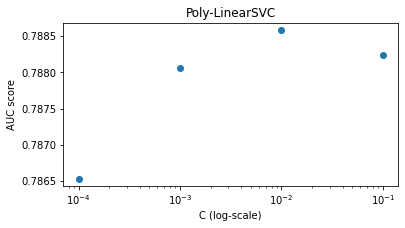

In [12]:
# LinearSVC
score_list = []
for C in np.logspace(-4, -1, 4):
    auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                  PolynomialFeatures(2, include_bias=False),
                                  StandardScaler(),
                                  LinearSVC(dual=False, C=C)),
                    f'Poly-LinearSVC {C=:.2g}')
    score_list.append((C, auc))
plot_score_list('Poly-LinearSVC', 'C', 'log')

# AUC 0.78903   time=0:00:29   Poly-LogisticRegression C=0.01
# AUC 0.78932   time=0:00:35   Poly-LogisticRegression C=0.024
# AUC 0.78953   time=0:00:45   Poly-LogisticRegression C=0.056
# AUC 0.78964   time=0:00:55   Poly-LogisticRegression C=0.13
# AUC 0.78966   time=0:01:10   Poly-LogisticRegression C=0.32
# AUC 0.78952   time=0:01:33   Poly-LogisticRegression C=0.75
# AUC 0.78933   time=0:02:06   Poly-LogisticRegression C=1.8
# AUC 0.78913   time=0:03:02   Poly-LogisticRegression C=4.2
# AUC 0.78895   time=0:04:49   Poly-LogisticRegression C=10


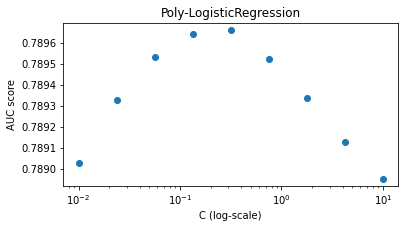

In [13]:
# LogisticRegression
score_list = []
for C in np.logspace(-2, 1, 9):
    auc = cross_val(make_pipeline(FunctionTransformer(np.log1p),
                                  PolynomialFeatures(2, include_bias=False),
                                  StandardScaler(),
                                  LogisticRegression(dual=False, C=C,
                                                     class_weight='balanced',
                                                     max_iter=1500,
                                                     random_state=1,
                                                     solver='newton-cg')),
                    f'Poly-LogisticRegression {C=:.2g}')
    score_list.append((C, auc))
plot_score_list('Poly-LogisticRegression', 'C', 'log')